In [19]:
from pyspark.sql import SparkSession
from operator import add

spark_session = SparkSession.builder\
        .master("spark://192.168.2.156:7077") \
        .appName("zhuoer_Project")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.cores.max", "2")\
        .config("spark.executor.instances", 2)\
        .config("spark.executor.cores", 1)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

In [20]:
import time
import psutil
import os
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

In [21]:
# Function to get current CPU and memory usage
def get_resource_usage():
    process = psutil.Process(os.getpid())
    cpu_percent = psutil.cpu_percent(interval=0.1)
    memory_info = process.memory_info()
    memory_mb = memory_info.rss / (1024 * 1024)  # Convert to MB
    return cpu_percent, memory_mb

In [22]:
# Define data files with their sizes
data_files = [
    "reddit_50k.json",   # 50k records
    "reddit_100k.json",   # 100k records
    "reddit_200k.json",  # 200k records
    "reddit_500k.json"   # 500k records
]

# Dictionary to store results
results = {
    "data_file": [],
    "record_count": [],
    "execution_time": [],
    "avg_cpu_percent": [],
    "max_cpu_percent": [],
    "avg_memory_mb": [],
    "max_memory_mb": []
}

In [23]:
# Run experiment for each data size
for data_file in data_files:
    hdfs_path = f"hdfs://192.168.2.156:9000/data/reddit/{data_file}"
    print(f"\n=== Running experiment with {data_file} ===")
    
    # Track CPU and memory usage
    cpu_measurements = []
    memory_measurements = []
    
    # Load data and measure execution time
    start_time = time.time()
    
    # Load the data
    df = spark_session.read.json(hdfs_path)
    
    # Example operations (modify according to your actual workload)
    # 1. Count records
    record_count = df.count()
    
    # 2. Perform some transformations and actions
    # Filter posts with more than 10 comments
    filtered_df = df.filter(col("content_len") > 50)
    long_comment_count = filtered_df.count()
    
    # 3. Group by subreddit and count posts
    subreddit_counts = df.groupBy("subreddit").count().cache()
    top_subreddits = subreddit_counts.orderBy(col("count").desc()).take(10)
    
    # Take resource measurements during execution
    cpu_percent, memory_mb = get_resource_usage()
    cpu_measurements.append(cpu_percent)
    memory_measurements.append(memory_mb)
    
    # End timing
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Take final resource measurement
    cpu_percent, memory_mb = get_resource_usage()
    cpu_measurements.append(cpu_percent)
    memory_measurements.append(memory_mb)
    
    # Calculate metrics
    avg_cpu = sum(cpu_measurements) / len(cpu_measurements)
    max_cpu = max(cpu_measurements)
    avg_memory = sum(memory_measurements) / len(memory_measurements)
    max_memory = max(memory_measurements)
    
    # Store results
    results["data_file"].append(data_file)
    results["record_count"].append(record_count)
    results["execution_time"].append(execution_time)
    results["avg_cpu_percent"].append(avg_cpu)
    results["max_cpu_percent"].append(max_cpu)
    results["avg_memory_mb"].append(avg_memory)
    results["max_memory_mb"].append(max_memory)
    
    # Print summary for this run
    print(f"Data file: {data_file}")
    print(f"Record count: {record_count}")
    print(f"Execution time: {execution_time:.2f} seconds")
    print(f"Avg CPU: {avg_cpu:.2f}%, Max CPU: {max_cpu:.2f}%")
    print(f"Avg Memory: {avg_memory:.2f} MB, Max Memory: {max_memory:.2f} MB")
    print(f"Posts longer than 50 words: {long_comment_count}")
    print("Top subreddits by post count:")
    for row in top_subreddits:
        print(f"  {row['subreddit']}: {row['count']}")


=== Running experiment with reddit_50k.json ===


Data file: reddit_50k.json
Record count: 99999
Execution time: 21.26 seconds
Avg CPU: 5.55%, Max CPU: 11.10%
Avg Memory: 141.24 MB, Max Memory: 141.24 MB
Posts longer than 50 words: 44283
Top subreddits by post count:
  None: 50182
  AskReddit: 11909
  leagueoflegends: 1256
  AdviceAnimals: 975
  funny: 880
  gaming: 762
  pics: 740
  politics: 738
  atheism: 703
  explainlikeimfive: 631

=== Running experiment with reddit_100k.json ===


Data file: reddit_100k.json
Record count: 200001
Execution time: 25.89 seconds
Avg CPU: 9.55%, Max CPU: 10.00%
Avg Memory: 141.24 MB, Max Memory: 141.24 MB
Posts longer than 50 words: 88568
Top subreddits by post count:
  None: 100333
  AskReddit: 23501
  leagueoflegends: 2367
  AdviceAnimals: 1869
  funny: 1778
  gaming: 1616
  pics: 1552
  politics: 1518
  atheism: 1427
  explainlikeimfive: 1144

=== Running experiment with reddit_200k.json ===


Data file: reddit_200k.json
Record count: 400001
Execution time: 40.48 seconds
Avg CPU: 10.00%, Max CPU: 20.00%
Avg Memory: 141.42 MB, Max Memory: 141.42 MB
Posts longer than 50 words: 177039
Top subreddits by post count:
  None: 200723
  AskReddit: 47418
  leagueoflegends: 4797
  AdviceAnimals: 3709
  funny: 3461
  gaming: 3144
  politics: 3124
  pics: 3064
  atheism: 2776
  todayilearned: 2276

=== Running experiment with reddit_500k.json ===


Data file: reddit_500k.json
Record count: 1000001
Execution time: 109.65 seconds
Avg CPU: 4.55%, Max CPU: 9.10%
Avg Memory: 141.42 MB, Max Memory: 141.42 MB
Posts longer than 50 words: 442263
Top subreddits by post count:
  None: 501789
  AskReddit: 117305
  leagueoflegends: 12088
  AdviceAnimals: 9413
  funny: 8578
  politics: 8005
  gaming: 7911
  pics: 7803
  atheism: 6766
  explainlikeimfive: 5701


In [24]:
# Create DataFrame from results
results_df = pd.DataFrame(results)
print("\n=== Summary of All Experiments ===")
print(results_df)


=== Summary of All Experiments ===
          data_file  record_count  execution_time  avg_cpu_percent  \
0   reddit_50k.json         99999       21.256491             5.55   
1  reddit_100k.json        200001       25.893648             9.55   
2  reddit_200k.json        400001       40.483748            10.00   
3  reddit_500k.json       1000001      109.650449             4.55   

   max_cpu_percent  avg_memory_mb  max_memory_mb  
0             11.1     141.238281     141.238281  
1             10.0     141.238281     141.238281  
2             20.0     141.421875     141.421875  
3              9.1     141.421875     141.421875  


Chart saved to data_volume_experiment_results.png


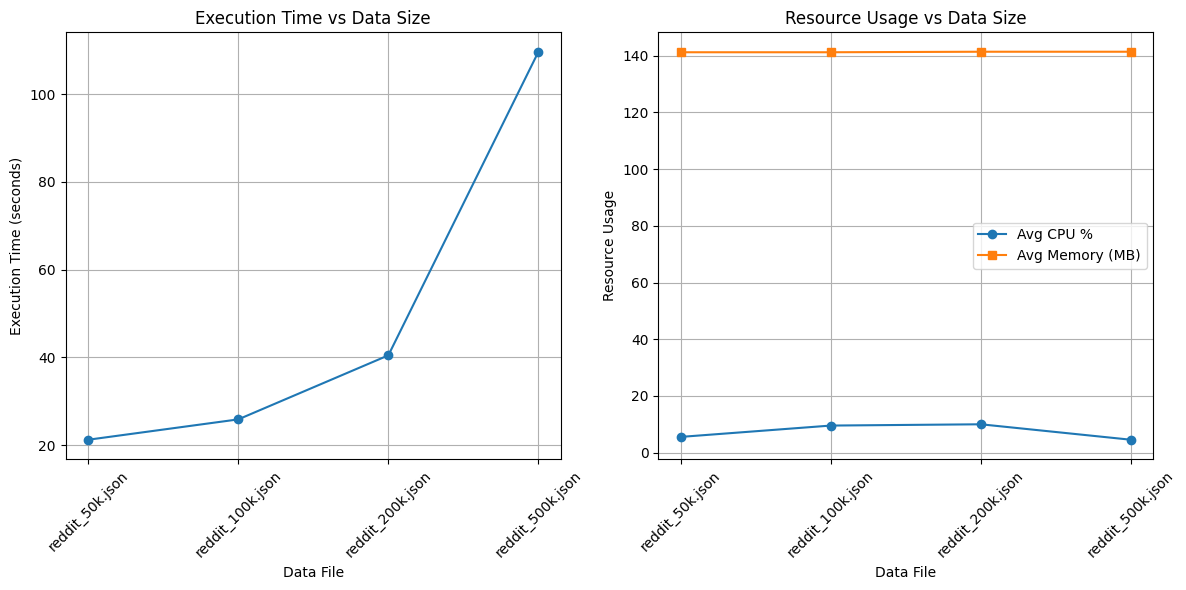

In [25]:
# Create visualization of execution time vs data size
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(results["data_file"], results["execution_time"], marker='o')
plt.title("Execution Time vs Data Size")
plt.xlabel("Data File")
plt.ylabel("Execution Time (seconds)")
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(results["data_file"], results["avg_cpu_percent"], marker='o', label="Avg CPU %")
plt.plot(results["data_file"], results["avg_memory_mb"], marker='s', label="Avg Memory (MB)")
plt.title("Resource Usage vs Data Size")
plt.xlabel("Data File")
plt.ylabel("Resource Usage")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("data_volume_experiment_results.png")
print("Chart saved to data_volume_experiment_results.png")

In [18]:
spark_session.stop()